In [151]:
! pip install torchinfo

In [152]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchinfo import summary


In [153]:
# Load Matlab data files

load_ice = sio.loadmat('hal_2018-12-12_ae.mat');
load_wet = sio.loadmat('hal_2018-12-12_ad.mat');
load_sheet = sio.loadmat('hal_2018-12-12_ai.mat');
load_dry = sio.loadmat('hal_2018-12-12_ac.mat');

In [154]:
# Calculating delta_dot
delta_dot_iceL = np.gradient(load_ice['y'][:,98]) / np.gradient(load_ice['t'].reshape(-1));
delta_dot_iceR = np.gradient(load_ice['y'][:,99]) / np.gradient(load_ice['t'].reshape(-1));
delta_dot_wetL = np.gradient(load_wet['y'][:,98]) / np.gradient(load_wet['t'].reshape(-1));
delta_dot_wetR = np.gradient(load_wet['y'][:,99]) / np.gradient(load_wet['t'].reshape(-1));
delta_dot_sheetL = np.gradient(load_sheet['y'][:,98]) / np.gradient(load_sheet['t'].reshape(-1));
delta_dot_sheetR = np.gradient(load_sheet['y'][:,99]) / np.gradient(load_sheet['t'].reshape(-1));
left_ddotIN = np.hstack([delta_dot_iceL,delta_dot_wetL,delta_dot_sheetL]);
right_ddotIN = np.hstack([delta_dot_iceR,delta_dot_wetR,delta_dot_sheetR]);

# Calculating mu 
mu_ice = 0.181976 * np.ones(load_ice['t'].shape[0]);
mu_wet = 0.715519 * np.ones(load_ice['t'].shape[0]);
mu_sheet = 0.246479 * np.ones(load_ice['t'].shape[0]);
mu = np.hstack([mu_ice,mu_wet,mu_sheet]);

In [155]:
# Training set

# creating input datasets all files

# First Ice then wet then ICE cubes this ensures better optimization as ice and ice sheets gives you the small values, 
# if both trained at the end then weights will not optimized well for dry surface.

# For consistency of the datalength we assume that we predict the friction
# until 40.500 sec or 20,251 time steps
# MATLAB uses 1-based indexing, Python uses 0-based indexing

# Only 10% conisedered for the validation and test set because the model should have to train on the secound highest dither, which is applied after 30 seconds or t[15000] in the dataset.
num_start = 5000;  # start from 5000th time step or at 10 seconds
num_end = 19500;  # total number of time steps to consider or endf at 39.000 seconds
num_steps = num_end - num_start + 1;  # total number of time steps to consider
num_valid = int(num_steps * 0.10);
num_test = int(num_steps * 0.10);
num_train = num_steps - num_valid - num_test;   
# This is how we can access correct key value pairs from dictionary in python [value for key, value in dictionary.items()]
# row vise vector instesd of column wise (coumn wiae is default in matlab)

def train_test_valid_split(data1, data2, data3 , num_train, num_valid, num_test,num_surfaces):
    """
    Splits the data into training, validation, and test sets.
    traindata = [data1.1,
                data2.1,
                data3.1]
    validdata = [data1.2,
                data2.2,
                data3.2]
    testdata = [data1.3,
                data2.3,
                data3.3]

    Args:
        data1 (np.ndarray): Data from the first surface.
        data2 (np.ndarray): Data from the second surface.
        data3 (np.ndarray): Data from the third surface.
        num_train (int): Number of training samples.
        num_valid (int): Number of validation samples.
        num_test (int): Number of test samples.
        num_surfaces (int): Number of surfaces.
    Returns:
        tuple: Training, validation, and test data as numpy arrays.
    """
    train_val = num_start + num_train
    valid_val = train_val + num_valid
    test_val = valid_val + num_test
    train_data = np.hstack ([data1[num_start:train_val], data2[num_start:train_val], data3[num_start:train_val]])
    valid_data = np.hstack ([data1[train_val:valid_val], data2[train_val:valid_val], data3[train_val:valid_val]])
    test_data = np.hstack ([data1[valid_val:test_val], data2[valid_val:test_val], data3[valid_val:test_val]])

    if num_train + num_valid + num_test != (np.size(train_data) + np.size(valid_data) + np.size(test_data)) / num_surfaces:
        print(num_train + num_valid + num_test)
        print((np.size(train_data) + np.size(valid_data) + np.size(test_data)) / num_surfaces)
        raise ValueError("The split does not cover the entire dataset. Please check the split sizes.")
    return train_data, valid_data, test_data

num_surfaces = 3  # Number of surfaces (ice, wet, sheet)
(left_steering_angles_train, left_steering_angles_valid, left_steering_angles_test) = train_test_valid_split(load_ice['y'][:,98], load_wet['y'][:,98], load_sheet['y'][:,98], num_train, num_valid, num_test,num_surfaces)
(right_steering_angles_train, right_steering_angles_valid, right_steering_angles_test) = train_test_valid_split(load_ice['y'][:,99], load_wet['y'][:,99], load_sheet['y'][:,99], num_train, num_valid, num_test,num_surfaces)
(left_steering_torques_train, left_steering_torques_valid, left_steering_torques_test) = train_test_valid_split(load_ice['y'][:,115], load_wet['y'][:,115], load_sheet['y'][:,115], num_train, num_valid, num_test,num_surfaces)
(right_steering_torques_train, right_steering_torques_valid, right_steering_torques_test) = train_test_valid_split(load_ice['y'][:,116], load_wet['y'][:,116], load_sheet['y'][:,116], num_train, num_valid, num_test,num_surfaces) 
(delta_dot_Left_train, delta_dot_Left_valid, delta_dot_Left_test) = train_test_valid_split(delta_dot_iceL, delta_dot_wetL, delta_dot_sheetL, num_train, num_valid, num_test,num_surfaces)
(delta_dot_Right_train, delta_dot_Right_valid, delta_dot_Right_test) = train_test_valid_split(delta_dot_iceR, delta_dot_wetR, delta_dot_sheetR, num_train, num_valid, num_test,num_surfaces)
(mu_train, mu_valid, mu_test) = train_test_valid_split(mu_ice, mu_wet, mu_sheet, num_train, num_valid, num_test,num_surfaces)


In [156]:
print(np.shape(left_steering_angles_train))

(34803,)


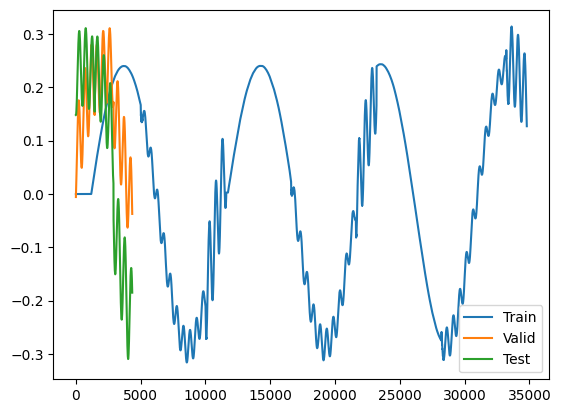

In [157]:
plt.figure()
plt.plot(right_steering_angles_train)
plt.plot(right_steering_angles_valid)
plt.plot(right_steering_angles_test)
plt.legend(['Train','Valid','Test'])

In [158]:
#p = np.gradient(load_ice['t'])

print(load_ice['t'].reshape(-1).shape)
print(load_ice['y'][:,98].shape)

(24306,)
(24306,)


In [159]:
print(np.shape(load_ice['y'][:,98]))
print(np.shape(load_sheet['y'][:,98]))
print(np.shape(load_wet['y'][:,98]))

(24306,)
(21877,)
(22633,)


In [160]:
print(np.shape(delta_dot_iceR))
print(np.shape(delta_dot_wetR))
print(np.shape(delta_dot_sheetR))
print(np.shape(delta_dot_iceL))
print(np.shape(delta_dot_wetL))
print(np.shape(delta_dot_sheetL))

(24306,)
(22633,)
(21877,)
(24306,)
(22633,)
(21877,)


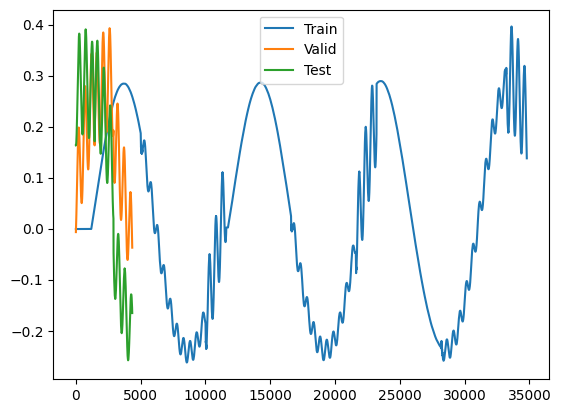

In [161]:
plt.figure()
plt.plot(left_steering_angles_train)
plt.plot(left_steering_angles_valid)
plt.plot(left_steering_angles_test)
plt.legend(['Train', 'Valid', 'Test'])
plt.show()

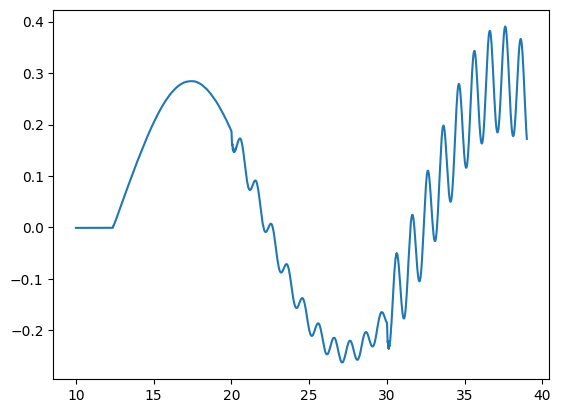

In [162]:
plt.figure()
plt.plot(load_ice['t'][num_start:num_end], load_ice['y'][num_start:num_end,98])

In [163]:
print(num_steps)
print(num_train)
print(num_valid)
print(num_test)

14501
11601
1450
1450


In [164]:
a = 19500-2900
print(a)
print(load_ice['t'][20250], load_ice['y'][:num_steps,98])

16600
[40.5] [-0.01232866 -0.01291107 -0.01346306 ... -0.22880427 -0.22892549
 -0.22903662]


In [165]:
print(load_ice['t'][15000])

[30.]


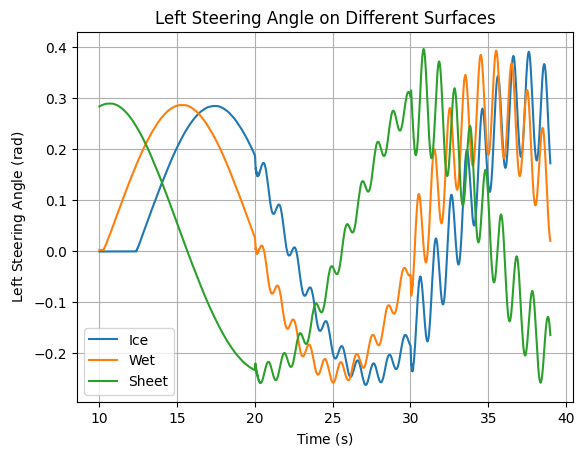

In [166]:
# In the new version of the matplot library, the hold function is removed.

plt.figure()
plt.plot(load_ice['t'][num_start:num_end].reshape(-1),load_ice['y'][num_start:num_end,98])
plt.plot(load_wet['t'][num_start:num_end].reshape(-1), load_wet['y'][num_start:num_end,98])
plt.plot(load_sheet['t'][num_start:num_end].reshape(-1), load_sheet['y'][num_start:num_end,98])
plt.legend(['Ice','Wet','Sheet'])
plt.xlabel('Time ($\mathrm{s}$)')
plt.ylabel('Left Steering Angle ($\mathrm{rad}$)')
plt.title('Left Steering Angle on Different Surfaces')
plt.grid()
plt.show()


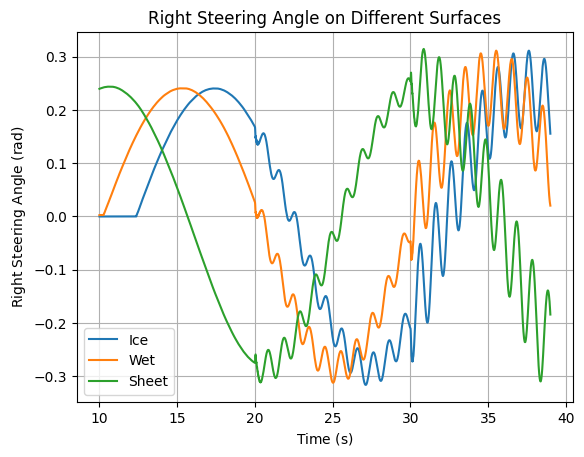

In [167]:
plt.figure()
plt.plot(load_ice['t'][num_start:num_end].reshape(-1),load_ice['y'][num_start:num_end,99])
plt.plot(load_wet['t'][num_start:num_end].reshape(-1), load_wet['y'][num_start:num_end,99])
plt.plot(load_sheet['t'][num_start:num_end].reshape(-1), load_sheet['y'][num_start:num_end,99])
plt.legend(['Ice','Wet','Sheet'])
plt.xlabel('Time ($\mathrm{s}$)')
plt.ylabel('Right Steering Angle ($\mathrm{rad}$)')
plt.title('Right Steering Angle on Different Surfaces')
plt.grid()
plt.show()

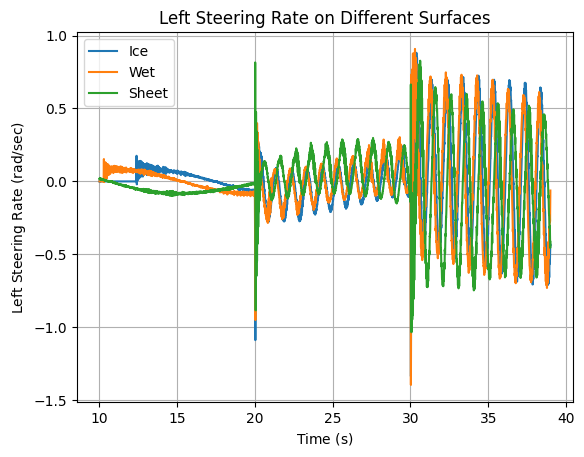

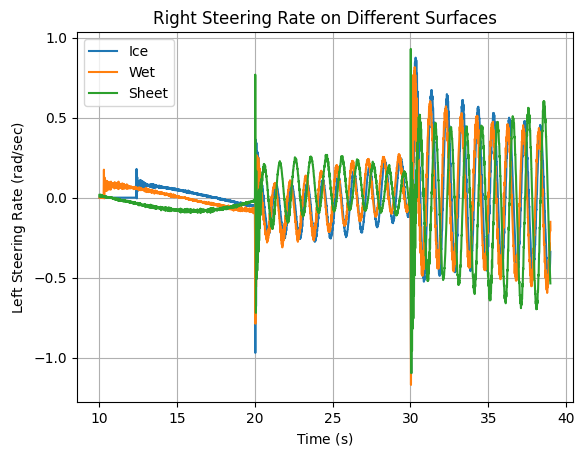

In [168]:
plt.figure()
plt.plot(load_ice['t'][num_start:num_end].reshape(-1),delta_dot_iceL[num_start:num_end])
plt.plot(load_wet['t'][num_start:num_end].reshape(-1), delta_dot_wetL[num_start:num_end])
plt.plot(load_sheet['t'][num_start:num_end].reshape(-1),delta_dot_sheetL[num_start:num_end])
plt.legend(['Ice','Wet','Sheet'])
plt.xlabel('Time ($\mathrm{s}$)')
plt.ylabel('Left Steering Rate ($\mathrm{rad/sec}$)')
plt.title('Left Steering Rate on Different Surfaces')
plt.grid()
plt.show()

plt.figure()
plt.plot(load_ice['t'][num_start:num_end].reshape(-1),delta_dot_iceR[num_start:num_end])
plt.plot(load_wet['t'][num_start:num_end].reshape(-1), delta_dot_wetR[num_start:num_end])
plt.plot(load_sheet['t'][num_start:num_end].reshape(-1),delta_dot_sheetR[num_start:num_end])
plt.legend(['Ice','Wet','Sheet'])
plt.xlabel('Time ($\mathrm{s}$)')
plt.ylabel('Left Steering Rate ($\mathrm{rad/sec}$)')
plt.title('Right Steering Rate on Different Surfaces')
plt.grid()
plt.show()


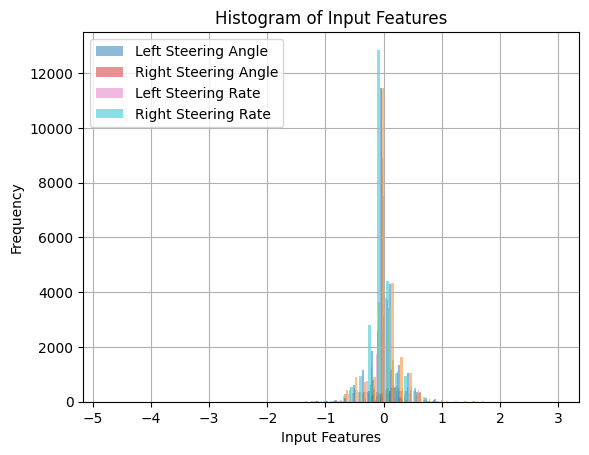

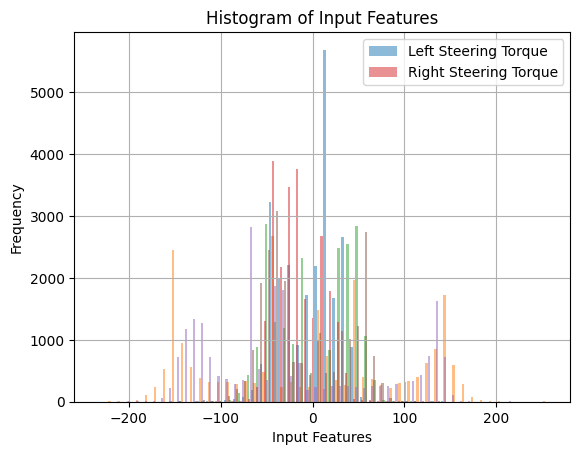

In [169]:
# Which normalization or standadization should have to use?

# Plot Histogram of each input feature
Langle_check = [load_ice['y'][:,98], load_wet['y'][:,98], load_sheet['y'][:,98]]
Rangle_check = [load_ice['y'][:,99], load_wet['y'][:,99], load_sheet['y'][:,99]]
Ltorque_check = [load_ice['y'][:,115], load_wet['y'][:,115], load_sheet['y'][:,115]]
Rtorque_check = [load_ice['y'][:,116], load_wet['y'][:,116], load_sheet['y'][:,116]]    
Lrate_check = [delta_dot_iceL, delta_dot_wetL, delta_dot_sheetL]
Rrate_check = [delta_dot_iceR, delta_dot_wetR, delta_dot_sheetR]
plt.figure()
plt.hist(Langle_check, bins=50, alpha=0.5, label='Left Steering Angle')
plt.hist(Rangle_check, bins=50, alpha=0.5, label='Right Steering Angle')
plt.hist(Lrate_check, bins=50, alpha=0.5, label='Left Steering Rate')
plt.hist(Rrate_check, bins=50, alpha=0.5, label='Right Steering Rate')
plt.xlabel('Input Features')
plt.ylabel('Frequency')
plt.title('Histogram of Input Features')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.hist(Ltorque_check, bins=50, alpha=0.5, label='Left Steering Torque')
plt.hist(Rtorque_check, bins=50, alpha=0.5, label='Right Steering Torque')
plt.xlabel('Input Features')
plt.ylabel('Frequency')
plt.title('Histogram of Input Features')
plt.legend()
plt.grid()
plt.show()

# Result:

# There is a suttle difference between the angles or rate of the angles and the torques. Furthermore, the physical units are also different. 
# To preserve the physical meaning of the data and their distributions, it is better to use the StandardScaler from sklearn.preprocessing. (i.e. , Standardization)


In [170]:
print(left_steering_angles_train.shape)
print(right_steering_angles_train.shape)
print(delta_dot_Left_train.shape) 
print(delta_dot_Right_train.shape)
print(left_steering_torques_train.shape)
print(right_steering_torques_train.shape)
   



(34803,)
(34803,)
(34803,)
(34803,)
(34803,)
(34803,)


In [171]:
print(left_steering_angles_valid.shape)
print(right_steering_angles_valid.shape)
print(delta_dot_Left_valid.shape) 
print(delta_dot_Right_valid.shape)
print(left_steering_torques_valid.shape)
print(right_steering_torques_valid.shape)

(4350,)
(4350,)
(4350,)
(4350,)
(4350,)
(4350,)


In [172]:
print(left_steering_angles_test.shape)
print(right_steering_angles_test.shape)
print(delta_dot_Left_test.shape) 
print(delta_dot_Right_test.shape)
print(left_steering_torques_test.shape)
print(right_steering_torques_test.shape)

(4350,)
(4350,)
(4350,)
(4350,)
(4350,)
(4350,)


In [173]:
# Standadization of the input data
input_scaler = StandardScaler()
train_data = np.stack([left_steering_angles_train, right_steering_angles_train, delta_dot_Left_train, delta_dot_Right_train, left_steering_torques_train, right_steering_torques_train], axis=1)
valid_data = np.stack([left_steering_angles_valid, right_steering_angles_valid, delta_dot_Left_valid, delta_dot_Right_valid, left_steering_torques_valid, right_steering_torques_valid], axis=1)
test_data = np.stack([left_steering_angles_test, right_steering_angles_test, delta_dot_Left_test, delta_dot_Right_test, left_steering_torques_test, right_steering_torques_test], axis=1)

input_train_scaled = input_scaler.fit_transform(train_data)

# Apply to validation and test sets
input_valid_scaled = input_scaler.transform(valid_data)
input_test_scaled = input_scaler.transform(test_data)

joblib.dump(input_scaler, 'steering_input_scaler.pkl')

# Standadization of ther output data
output_scaler = StandardScaler()
output_train_scaled = output_scaler.fit_transform(mu_train.reshape(-1, 1))      # reshape to 2D array for StandardScaler
output_valid_scaled = output_scaler.transform(mu_valid.reshape(-1, 1))
output_test_scaled = output_scaler.transform(mu_test.reshape(-1, 1))
joblib.dump(output_scaler, 'steering_output_scaler.pkl')



['steering_output_scaler.pkl']

In [174]:
print(np.shape(input_train_scaled))
print(np.shape(input_valid_scaled))
print(np.shape(input_test_scaled))
print(np.shape(output_train_scaled))
print(np.shape(output_valid_scaled))
print(np.shape(output_test_scaled))

(34803, 6)
(4350, 6)
(4350, 6)
(34803, 1)
(4350, 1)
(4350, 1)


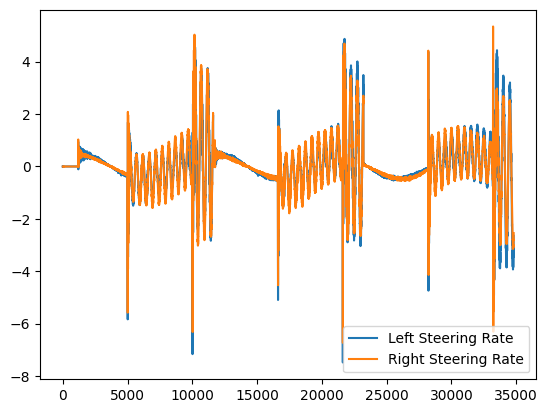

In [175]:
plt.figure()
# plt.plot(input_train_scaled[:, 0], label='Left Steering Angle')
# plt.plot(input_train_scaled[:, 1], label='Right Steering Angle')
plt.plot(input_train_scaled[:, 2], label='Left Steering Rate')
plt.plot(input_train_scaled[:, 3], label='Right Steering Rate')
# plt.plot(input_train_scaled[:, 4], label='Left Steering Torque')
# plt.plot(input_train_scaled[:, 5], label='Right Steering Torque')
plt.legend()

In [176]:
## Create sequence windows for 3d input data
# As pytorch takes only 3d input data for LSTM

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


seq_length = 10

X_train_seq, y_train_seq = create_sequences(input_train_scaled , output_train_scaled, seq_length)
X_val_seq, y_val_seq = create_sequences(input_valid_scaled, output_valid_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(input_test_scaled, output_test_scaled, seq_length)

In [177]:
print(np.shape(X_train_seq))
print(np.shape(y_train_seq))
print(np.shape(X_val_seq))
print(np.shape(y_val_seq))
print(np.shape(X_test_seq))
print(np.shape(y_test_seq))

(34793, 10, 6)
(34793, 1)
(4340, 10, 6)
(4340, 1)
(4340, 10, 6)
(4340, 1)


In [178]:
# Creating pytorch tensors 
# AS pytorch only works with the tensors and not with the numpy arrays
batch_size = 64  # Batch size for DataLoader
# Convert trainining datsets to pytorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# You can shuffle the sequences (not the raw data!), as long as each sequence is complete and independent.
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)       # DataLoader is used to load the data in batches automatically without slicing the data manually

# Convert validation datsets to pytorch tensors
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

# Convert test datsets to pytorch tensors
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [179]:
print(np.shape(X_train_seq))

(34793, 10, 6)


In [180]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)

print(X_test_tensor.shape)

torch.Size([34793, 10, 6])
torch.Size([34793, 1])
torch.Size([4340, 10, 6])


In [181]:
# LSTM Model Definition

class FrictionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FrictionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        out, _ = self.lstm(x)  # out: (batch_size, seq_length, hidden_size)
        out = out[:, -1, :]    # Get the last time step's output
        out = self.fc(out)     # Final output
        return out
    
model = FrictionLSTM(input_size=6, hidden_size=64, num_layers=2, output_size=2)
summary(model, input_size=(batch_size, seq_length, 6))

Layer (type:depth-idx)                   Output Shape              Param #
FrictionLSTM                             [64, 2]                   --
├─LSTM: 1-1                              [64, 10, 64]              51,712
├─Linear: 1-2                            [64, 2]                   130
Total params: 51,842
Trainable params: 51,842
Non-trainable params: 0
Total mult-adds (M): 33.10
Input size (MB): 0.02
Forward/backward pass size (MB): 0.33
Params size (MB): 0.21
Estimated Total Size (MB): 0.55

In [182]:
# Defining Training Function

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer with learning rate of 0.001

def train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            y_pred = model(X_batch).squeeze()

            # Compute loss
            loss = loss_fn(y_pred, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)

                y_val_pred = model(X_val).squeeze()
                loss = loss_fn(y_val_pred, y_val)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")


In [194]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100, device=device)


In [195]:
# Saving and Loading Model again
torch.save(model.state_dict(), 'friction_lstm_model.pth')
# Load the model
model = FrictionLSTM(input_size=6, hidden_size=64, num_layers=2, output_size=2)
model.load_state_dict(torch.load('friction_lstm_model.pth'))
model = model.to(device)

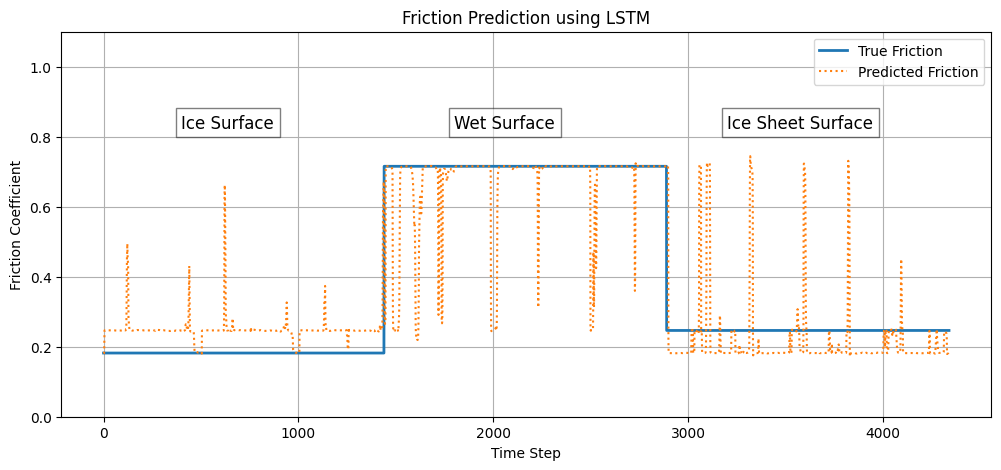

In [196]:
model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).squeeze().cpu().numpy()
        predictions.extend(y_pred)

# Make sure predictions and targets are numpy arrays                                     
y_test_true = y_test_seq.reshape(-1, 1)

# Inverse transform both
y_pred_orig = output_scaler.inverse_transform(predictions)
y_true_orig = output_scaler.inverse_transform(y_test_true)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y_true_orig)), y_true_orig, label='True Friction', linewidth=2)
plt.plot(np.arange(len(y_pred_orig)), y_pred_orig[:,1], label='Predicted Friction', linestyle=':')
plt.xlabel('Time Step')
plt.ylabel('Friction Coefficient')
plt.title('Friction Prediction using LSTM')
plt.legend()
plt.text(400, 0.825, 'Ice Surface', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.text(1800, 0.825, 'Wet Surface', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.text(3200, 0.825, 'Ice Sheet Surface', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)                                    
plt.ylim([0, 1.1])
plt.show()

In [197]:
rmse = mean_squared_error(y_true_orig, y_pred_orig[:,1], squared=True)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.0129


# Dry Surface Friction Prediction



In [198]:
# Delta_dot for dry surface

delta_dot_dryL = np.gradient(load_dry['y'][:,98]) / np.gradient(load_dry['t'].reshape(-1));
delta_dot_dryR = np.gradient(load_dry['y'][:,99]) / np.gradient(load_dry['t'].reshape(-1));
left_ddotIN_dry = delta_dot_dryL;
right_ddotIN_dry = delta_dot_dryR;

In [199]:
# Standadization

test_data_dry = np.stack([load_dry['y'][:,98], load_dry['y'][:,99], left_ddotIN_dry, right_ddotIN_dry, load_dry['y'][:,115], load_dry['y'][:,116]], axis=1)
test_data_dry_scaled = input_scaler.transform(test_data_dry)
test_data_dry_seq, _ = create_sequences(test_data_dry_scaled, np.zeros(test_data_dry_scaled.shape[0]), seq_length)

# DataLoader for dry surface
test_dataset_dry = TensorDataset(torch.tensor(test_data_dry_seq, dtype=torch.float32))
test_loader_dry = DataLoader(test_dataset_dry, batch_size=64, shuffle=False)


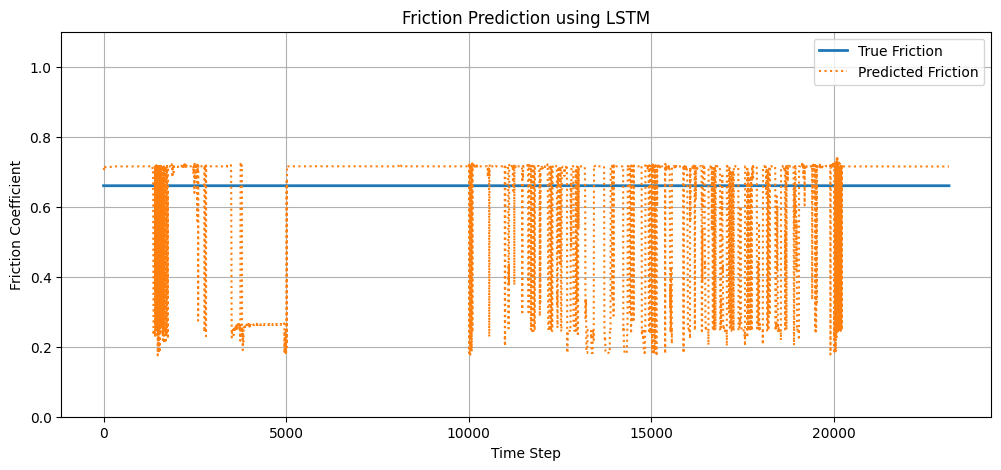

In [210]:
# Dry friction Prediction
model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader_dry:
        X_batch = X_batch[0].to(device)
        y_pred_dry = model(X_batch).squeeze().cpu().numpy()
        predictions.extend(y_pred_dry)

# Make sure predictions and targets are numpy arrays                                     
# y_test_true = y_test_seq.reshape(-1, 1)

# Inverse transform both
y_pred_orig_dry = output_scaler.inverse_transform(predictions)
y_true_orig_dry = 0.66 * np.ones(len(y_pred_orig_dry))

plt.figure(figsize=(12, 5))
plt.plot( y_true_orig_dry, label='True Friction', linewidth=2)
plt.plot(y_pred_orig_dry[:,0], label='Predicted Friction', linestyle=':')
plt.xlabel('Time Step')
plt.ylabel('Friction Coefficient')
plt.title('Friction Prediction using LSTM')
plt.legend()
plt.grid(True)                                    
plt.ylim([0, 1.1])
plt.show()

In [212]:
rmse_dry = mean_squared_error(y_true_orig_dry, y_pred_orig_dry[:,0], squared=False)
print(f"Test RMSE: {rmse_dry:.4f}")

Test RMSE: 0.1810


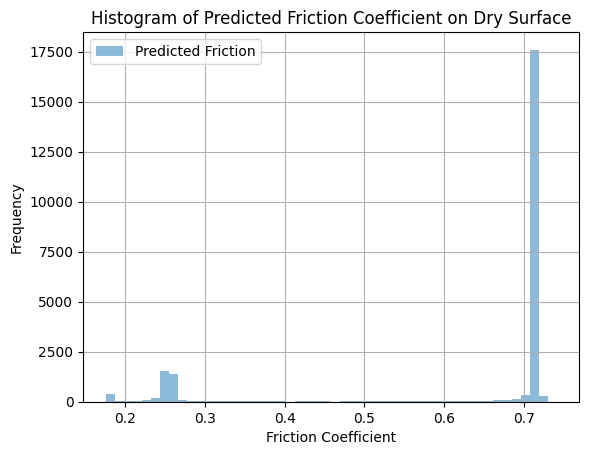

In [213]:
plt.figure()
plt.hist(y_pred_orig_dry[:,0], bins=50, alpha=0.5, label='Predicted Friction')
plt.xlabel('Friction Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Friction Coefficient on Dry Surface')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# For testing also should I have create a sequence of a datasets?